In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import UnivariateSpline

# Set plotting style to seaborn
sns.set(style="whitegrid")

# Turn off grid 
plt.rc('axes', grid=False)

# Give all the plots LaTex font and text    
rc('text', usetex=True)
rc('font', family='serif')

/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_37016/823944181.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read Me

The goal of this notebook is to determine as to what extend the synthetic data generated by the GAN is combarable to real option data.

## Data Preprocessing

As input, we have synthetic data generate by the GAN and actual preprocessed data 

In [3]:
# Read input data to pandas dataframe 
#df_synthetic = pd.read_excel(r"C:\Users\koens\OneDrive\Bureaublad\Research-Practicum\Data\Synthetic Data\synthetic_gold_lowsamples_7500.xlsx")
df_real = pd.read_excel("/Users/koensmallegange/Desktop/Research-Practicum/Data/Real Data/FUT_Option.xlsx")
df_simulated = pd.read_excel("/Users/koensmallegange/Desktop/Research-Practicum/Data/Synthetic Data/Synthetic gold 26-1 100k epochs.xlsx")


### First we preprocess the real data

In [4]:

# Convert to datetime
df_real['date'] = pd.to_datetime(df_real['date'])
df_real['futures_expiration_date'] = pd.to_datetime(df_real['futures_expiration_date'])
df_real['options_expiration_date'] = pd.to_datetime(df_real['options_expiration_date'], errors='coerce')

df_real = df_real[df_real['options_expiration_date'] >= '2019-10-18']
df_real['TTM'] = (df_real['options_expiration_date'] - df_real['date']).dt.days / 365.25

# # Remove zero bid/asks 
# df_real = df_real.drop(df_real[df_real['bid'] == 0].index)
# df_real = df_real.drop(df_real[df_real['ask'] == 0].index)

# Rescale
df_real['futures_close'] = df_real['futures_close']/1000000
df_real['strike'] = df_real['strike']/1000000
df_real['bid'] = df_real['bid']/1000000
df_real['ask'] = df_real['ask']/1000000
df_real['settlement'] = df_real['settlement']/1000000
df_real['vega'] = df_real['vega']/1000000

# Isolate call and put
df_real_call = df_real[df_real['call_put'] == 'C'].copy()
df_real_put = df_real[df_real['call_put'] == 'P'].copy()

# Sort by date
df_real_call.sort_values('date', inplace=True)
df_real_put.sort_values('date', inplace=True)

# Drop non-numeric columns if there are any
df_real = df_real_call.select_dtypes(include=[np.number])
df_real = df_real.drop(['delta', 'vega', 'gamma', 'theta'], axis=1)

# Filter out rows with IV > 1000
mask = df_real['iv'] > 1000
df_real = df_real[~mask]

# Print some stats about the data 
#print(len(df_synthetic))
print(len(df_real))

5211


In [5]:
df_real = df_real.reset_index(drop=True)
df_real

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,TTM
0,1483.500000,1275.0,0.0,0.0,208.600006,0.651953,0.651953,0,0,0.008214
1,1523.199951,1240.0,0.0,0.0,293.299988,0.155148,0.155148,0,0,1.533196
2,1523.199951,1230.0,0.0,0.0,302.200012,0.157257,0.157257,0,0,1.533196
3,1523.199951,1225.0,0.0,0.0,306.600006,0.158140,0.158140,0,0,1.533196
4,1523.199951,1220.0,0.0,0.0,311.100006,0.159270,0.159270,0,0,1.533196
...,...,...,...,...,...,...,...,...,...,...
5206,1504.900024,1095.0,0.0,0.0,409.899994,0.236580,0.236580,0,0,0.695414
5207,1504.900024,1090.0,0.0,0.0,414.899994,0.239999,0.239999,0,0,0.695414
5208,1504.900024,1085.0,0.0,0.0,419.899994,0.243437,0.243437,0,0,0.695414
5209,1504.900024,1175.0,0.0,0.0,329.899994,0.183995,0.183995,0,0,0.695414


## Calendar Spread Arbitrage
Calendar spread arbitrage, involving buying and selling options contracts with different expiration dates but the same strike price, is primarily designed for market-neutral strategies and aims to profit from differences in volatility and time decay. This approach is suitable for experienced options traders who understand the nuances of market movements and can manage the risks involved.

For American-style options, which can be exercised at any time before expiration, the strategy becomes more complex. The flexibility of American-style options to be exercised early introduces additional factors to consider, such as the risk of early assignment, especially for short-term contracts and in situations where the options' expiration dates are close to dividend dates. Early assignment could significantly impact the strategy's outcome.

When implementing calendar spread strategies with American-style options, it's crucial to carefully monitor the market, including volatility levels, time decay (theta), and the option's sensitivity to the underlying asset's price movements (delta). Traders should also be aware of any upcoming dividend dates or significant market events that might affect the strategy.





##### Compare Strikes and Prices:
For each option with a given TTM, compare its strike price and option price with options of a different TTM.

##### Identify Price Discrepancies: 
Look for situations where the price difference between short-term and long-term options suggests an arbitrage opportunity. This could be, for example, where the price of a long-term option is unexpectedly lower than a short-term option, considering time value and other factors.


This example code assumes your DataFrame (df_real) has columns like 'TTM', 'strike', and 'option_price'. The logic checks each option against options with different TTMs but the same strike price, looking for situations where buying the short-term option and selling the long-term option (or vice versa) might be profitable.

Remember, this is a simplified example. In a real-world application, you'd need to consider transaction costs, the risk of early exercise, and other market conditions. Thorough back-testing and risk assessment are essential.

## Calendar Spread Arbitrage (Gatheral & Jacquier, 2013)
Definition 2.2. A volatility surface w is free of calendar spread arbitrage if
∂tw(k, t) ≥ 0, for all k ∈ R and t > 0.

Volatility Surface (w): In options trading, the volatility surface is a three-dimensional plot that shows implied volatility as a function of both option strike price (k) and time to maturity (t). It's a crucial tool used to understand how the market's expectation of volatility varies for different options on the same underlying asset.

Calendar Spread Arbitrage: This type of arbitrage involves taking advantage of price differences between options with the same strike price but different expiration dates. A calendar spread is created by entering into a long and short position on options with the same strike price but different maturities.

Condition for No Arbitrage (∂tw(k, t) ≥ 0): The condition stated in the definition (∂tw(k, t) ≥ 0) tells us that for the volatility surface to be free of calendar spread arbitrage opportunities, the partial derivative of the implied volatility w with respect to time t must be non-negative for all strike prices k and for all times t greater than 0.

∂tw(k, t): This represents the rate of change of implied volatility with respect to time. In simpler terms, it's about how the implied volatility is expected to change as the time to expiration changes.
≥ 0: This indicates that the implied volatility should not decrease as time increases. If implied volatility were to decrease with time, it could indicate an arbitrage opportunity, where traders could profit from the discrepancy in implied volatilities for options with different maturities.

In essence, this definition is saying that a volatility surface is considered to be free from calendar spread arbitrage if the implied volatility doesn't decrease as the time to maturity increases, for any strike price. This is a theoretical condition to ensure the fairness and stability of pricing in options markets.

---

To test for calendar spread arbitrage: calculate the partial derivative of implied volatility with respect to time for each option and check if it's non-negative across all strike prices. 

Columns used
- implied volatility
- strike price (k)
- time to maturity (t) (Time to maturity should be in a consistent time unit (e.g., days))

Calculate Partial Derivative: For each strike price, calculate the rate of change of implied volatility with respect to time. This can be done using differences in implied volatility between options with slightly different maturities.

Check the Condition: Verify that the calculated rate of change is non-negative for each strike price.



In [6]:
# Sort the DataFrame for correct differentiation
df_real.sort_values(by=['strike', 'TTM'], inplace=True)

# Calculate the finite difference
df_real['iv_change'] = df_real.groupby('strike')['iv'].diff()
df_real['time_change'] = df_real.groupby('strike')['TTM'].diff()

# Calculate the rate of change of implied volatility with respect to time
df_real['iv_rate_of_change'] = df_real['iv_change'] / df_real['time_change']

# Handle NaN values
df_real.dropna(subset=['iv_rate_of_change'], inplace=True)

# Check if the condition is met
df_real['no_arbitrage_condition'] = df_real['iv_rate_of_change'] >= 0

# Filter to find where the condition is not met
arbitrage_CSA = df_real[df_real['no_arbitrage_condition'] == False]


This code adds a new column arbitrage_magnitude to your arbitrage_CSA DataFrame, which represents the magnitude of each arbitrage opportunity as a percentage of the closing price of the underlying asset.

In [7]:
# Calculate the percentage difference in implied volatility relative to the closing price
arbitrage_CSA['arbitrage_magnitude'] = (arbitrage_CSA['iv_change'] / arbitrage_CSA['futures_close']) * -100


/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_37016/3510383914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arbitrage_CSA['arbitrage_magnitude'] = (arbitrage_CSA['iv_change'] / arbitrage_CSA['futures_close']) * -100


In [8]:
# Filter out rows where 'arbitrage_magnitude' is less than 0.01%
significant_arbitrage = arbitrage_CSA[arbitrage_CSA['arbitrage_magnitude'] >= 0.02]

# This will give you a DataFrame with only the rows where 'arbitrage_magnitude' is 0.01% or more
significant_arbitrage

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,TTM,iv_change,time_change,iv_rate_of_change,no_arbitrage_condition,arbitrage_magnitude
5075,1500.400024,725.0,0.000000e+00,0.000000e+00,7.754000e+02,0.565364,0.565364,0,0,0.613279,-0.407718,0.501027,-0.813765,False,0.027174
3611,1483.500000,920.0,0.000000e+00,0.000000e+00,5.635000e+02,0.647698,0.647698,0,0,0.112252,-0.348332,0.076660,-4.543867,False,0.023480
3610,1483.500000,925.0,0.000000e+00,0.000000e+00,5.585000e+02,0.640403,0.640403,0,0,0.112252,-0.344077,0.076660,-4.488362,False,0.023194
3609,1483.500000,930.0,0.000000e+00,0.000000e+00,5.535000e+02,0.633108,0.633108,0,2,0.112252,-0.340430,0.076660,-4.440788,False,0.022948
3665,1483.500000,940.0,0.000000e+00,0.000000e+00,5.435000e+02,0.618518,0.618518,0,0,0.112252,-0.332527,0.076660,-4.337696,False,0.022415
3666,1483.500000,950.0,0.000000e+00,0.000000e+00,5.335000e+02,0.604080,0.604080,0,0,0.112252,-0.325080,0.076660,-4.240552,False,0.021913
3667,1483.500000,960.0,0.000000e+00,0.000000e+00,5.235000e+02,0.589946,0.589946,0,0,0.112252,-0.317329,0.076660,-4.139443,False,0.021391
3668,1483.500000,970.0,0.000000e+00,0.000000e+00,5.135000e+02,0.575812,0.575812,0,0,0.112252,-0.309579,0.076660,-4.038347,False,0.020868
3725,1483.500000,975.0,0.000000e+00,0.000000e+00,5.085000e+02,0.568821,0.568821,0,1,0.112252,-0.305627,0.076660,-3.986795,False,0.020602
3724,1483.500000,980.0,0.000000e+00,0.000000e+00,5.035000e+02,0.561830,0.561830,0,0,0.112252,-0.302284,0.076660,-3.943187,False,0.020376


## same as above but with simulated data (Calendar Spread Arbitrage)

In [9]:
# Sort the DataFrame for correct differentiation
df_simulated.sort_values(by=['strike', 'TTM'], inplace=True)

# Calculate the finite difference
df_simulated['iv_change'] = df_simulated.groupby('strike')['iv'].diff()
df_simulated['time_change'] = df_simulated.groupby('strike')['TTM'].diff()

# Calculate the rate of change of implied volatility with respect to time
df_simulated['iv_rate_of_change'] = df_simulated['iv_change'] / df_simulated['time_change']

# Handle NaN values
df_simulated.dropna(subset=['iv_rate_of_change'], inplace=True)

# Check if the condition is met
df_simulated['no_arbitrage_condition'] = df_simulated['iv_rate_of_change'] >= 0

# Filter to find where the condition is not met
arbitrage_CSA_simulated = df_simulated[df_simulated['no_arbitrage_condition'] == False]


In [10]:
# Calculate the percentage difference in implied volatility relative to the closing price
arbitrage_CSA_simulated['arbitrage_magnitude'] = (arbitrage_CSA_simulated['iv_change'] / arbitrage_CSA_simulated['futures_close']) * -100


/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_37016/3587784797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arbitrage_CSA_simulated['arbitrage_magnitude'] = (arbitrage_CSA_simulated['iv_change'] / arbitrage_CSA_simulated['futures_close']) * -100


In [11]:
# Filter out rows where 'arbitrage_magnitude' is less than 0.01%
significant_arbitrage_simulated = arbitrage_CSA_simulated[arbitrage_CSA_simulated['arbitrage_magnitude'] >= 0.01]

# This will give you a DataFrame with only the rows where 'arbitrage_magnitude' is 0.01% or more
significant_arbitrage_simulated

,Unnamed: 0,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,TTM,Moneyness,iv_change,time_change,iv_rate_of_change,no_arbitrage_condition,arbitrage_magnitude
1261,1261,1497.388393,895,0.001713,0.014337,643.126855,0.461865,0.457351,0.000000,0.000000,0.428571,0.597707,-0.187896,0.285714,-0.657637,False,0.012548
507,507,1494.584304,960,0.026979,0.140364,551.831344,0.415305,0.403731,0.000000,0.000000,0.428571,0.642319,-0.478428,0.428571,-1.116333,False,0.032011
5351,5351,1483.829354,995,0.026423,0.029876,473.903593,0.798871,0.827572,0.000000,0.000000,0.000000,0.670562,-0.171462,0.000000,-inf,False,0.011555
2104,2104,1497.528491,995,0.021485,0.050625,529.202767,0.377063,0.377963,0.000000,0.000000,0.428571,0.664428,-0.197703,0.285714,-0.691960,False,0.013202
5892,5892,1498.611137,1000,0.009519,0.012422,540.818400,0.367320,0.378674,0.000000,0.000000,0.428571,0.667285,-0.448865,0.428571,-1.047351,False,0.029952
500,500,1500.485805,1045,0.035964,0.048732,489.050165,0.315236,0.323336,0.000000,0.000000,0.571429,0.696441,-0.297580,0.571429,-0.520766,False,0.019832
2023,2023,1487.942293,1050,0.084562,0.148178,441.261977,0.428396,0.432767,0.000000,0.000000,0.142857,0.705673,-0.475774,0.142857,-3.330421,False,0.031975
3782,3782,1496.094104,1070,0.139365,0.299050,436.143471,0.314215,0.310827,0.000000,0.000000,0.428571,0.715196,-0.202977,0.428571,-0.473614,False,0.013567
3572,3572,1486.939328,1085,0.074998,0.105991,396.827431,0.423548,0.433513,0.000000,0.000000,0.142857,0.729687,-0.177042,0.142857,-1.239295,False,0.011906
2848,2848,1493.648489,1090,0.126465,0.205014,409.761982,0.314876,0.311104,0.000000,0.000000,0.428571,0.729757,-0.153161,0.285714,-0.536062,False,0.010254


<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_37016/1805620369.py:6: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Potential Arbitrage (\%)')
/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_37016/1805620369.py:6: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Potential Arbitrage (\%)')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/koensmallegange/Desktop/Research-Practicum/Src/Images/Calendar Spread.png'

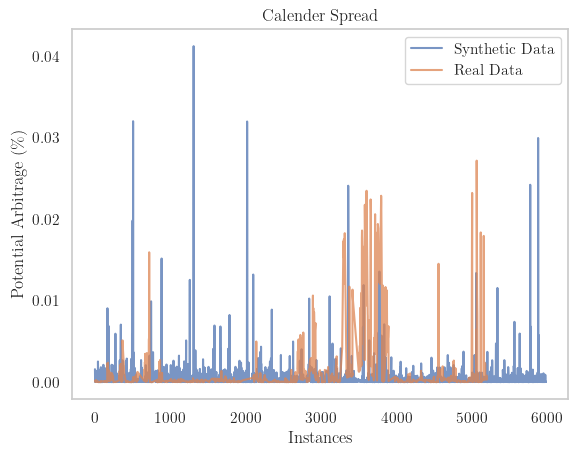

In [12]:
arbitrage_CSA_simulated_sorted = arbitrage_CSA_simulated.sort_index()
arbitrage_CSA_sorted = arbitrage_CSA.sort_index()

plt.plot(arbitrage_CSA_simulated_sorted['arbitrage_magnitude'], alpha=0.75, label = 'Synthetic Data')
plt.plot(arbitrage_CSA_sorted['arbitrage_magnitude'], alpha=0.75, label = 'Real Data')
plt.ylabel('Potential Arbitrage (\%)')
plt.xlabel('Instances')
plt.title('Calender Spread')
plt.legend()
plt.savefig('/Users/koensmallegange/Desktop/Research-Practicum/Src/Images/Calendar Spread.png')
plt.show()



### note: American Style Options, are more complex and should be tested on CSA in additional ways

American Style Options: These can be exercised at any time before expiration. The early exercise feature adds complexity to the pricing and arbitrage considerations. While the condition ∂tw(k, t) ≥ 0 is still relevant, additional factors such as the possibility of early exercise and the impact of dividends must be taken into account when assessing arbitrage opportunities. In the case of American options, the price also reflects the value of the option's flexibility to be exercised early, which can affect the volatility surface.

In practice, the analysis of calendar spread arbitrage in American options is more complex due to these additional factors. The condition mentioned is a necessary one, but it might not be sufficient on its own to rule out arbitrage opportunities, especially when early exercise and dividends are significant factors

## Butterfly Arbitrage (Gatheral & Jacquier, 2013)

To test for butterfly arbitrage opportunities in a dataset with American-style options, you can use the concept of the probability density function derived from option prices. For European options, the absence of butterfly arbitrage is confirmed if the corresponding density is non-negative. This is typically represented by the second derivative of the call price with respect to the strike price being greater than or equal to zero.

For American options, the task is more complex because you can't directly use the same approach due to the possibility of early exercise. However, you could approximate the test for butterfly arbitrage by considering only those options far enough from expiration where early exercise is less likely to be optimal due to the time value of money.


Lemma 2.2. A slice is free of butterfly arbitrage if and only if g(k) ≥ 0 for all k ∈ R
and lim k→+∞ d+(k) = −∞.


Notes on code below

Remember, this is a heuristic approach and doesn't account for all the complexities of American options, particularly around dividends and early exercise. The threshold for what counts as "far enough from expiration" needs to be determined based on the specifics of your options and market conditions.

In [144]:
# Function to approximate the second derivative of price with respect to strike
def approximate_density(df_real):
    # Filter options far from expiration
    df_far_from_expiration = df_real[df_real['TTM'] > threshold]  # Choose an appropriate threshold

    # Calculate the second derivative for each TTM segment
    density_results = []
    for TTM in df_far_from_expiration['TTM'].unique():
        segment = df_far_from_expiration[df_far_from_expiration['TTM'] == TTM]
        segment.sort_values('strike', inplace=True)

        # Assuming 'settlement' is the column name for the settlement prices in 'segment'
        spline = UnivariateSpline(segment['strike'], segment['settlement'], k=3, s=0)
        d2_price_d_strike2 = spline.derivative(n=2)

        strike_range = np.linspace(segment['strike'].min(), segment['strike'].max(), num=200)
        for k in strike_range:
            density = d2_price_d_strike2(k)
            if density < 0:
                # Interpolate the settlement price for the strike 'k'
                settlement_price = spline(k)
                density_results.append({
                    'TTM': TTM,
                    'strike': k,
                    'density': density,
                    'settlement': settlement_price  # Include the interpolated settlement price
                })

    return pd.DataFrame(density_results)

# Define an appropriate threshold for 'far from expiration'
threshold = 0.12  # for example, 0.12 years

# Use the function to check for butterfly arbitrage
butterfly_arbitrage_df = approximate_density(df_real)

# Check if there are any potential butterfly arbitrage opportunities
if butterfly_arbitrage_df.empty:
    print("No butterfly arbitrage opportunities found.")
else:
    print("Potential butterfly arbitrage opportunities detected:")

/var/folders/n_/ckxw6r6s2kd_8cdnwww5y4hc0000gn/T/ipykernel_2388/2859523655.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment.sort_values('strike', inplace=True)


Potential butterfly arbitrage opportunities detected:


In [139]:
# Assuming 'option_price' is the column representing the price of the option
# Calculate the magnitude of the arbitrage opportunity as a percentage of the option price
butterfly_arbitrage_df['arbitrage_percentage'] = abs(butterfly_arbitrage_df['density'] / butterfly_arbitrage_df['settlement']) * 100

# Filter opportunities larger than 0.5%
significant_butterfly_arbitrage = butterfly_arbitrage_df[butterfly_arbitrage_df['arbitrage_percentage'] > 0.5]
significant_butterfly_arbitrage

,TTM,strike,density,settlement,arbitrage_percentage
271,0.197125,1860.552764,-0.008857760978572375,0.9777109360540791,0.905969
273,0.197125,1899.748744,-0.0018877034992473769,-0.003654645990671758,51.652157
274,0.197125,1906.281407,-0.0013505517034610788,0.05489967133619287,2.460036
275,0.197125,1912.814070,-0.000693884587564904,0.055819520321368644,1.243086
278,0.197125,1952.010050,-0.000127759457882641,0.0017879778114799673,7.145472
279,0.197125,1958.542714,-8.067754728657694e-05,0.004335211961047378,1.860983
280,0.197125,1965.075377,-3.3595636690511246e-05,0.0034394761120210104,0.976766
281,0.197125,1997.738693,-5.194549787903558e-06,-0.00019878914936203077,2.613095
282,0.197125,2004.271357,-7.863128621354714e-06,0.00025645647789272465,3.066067
283,0.197125,2010.804020,-5.3850012982610695e-06,0.00038052395213857704,1.415154


## same as above but with simulated data (Butterfly Arbitrage)

In [145]:
# Function to approximate the second derivative of price with respect to strike
def approximate_density(df_simulated):
    df_far_from_expiration = df_simulated[df_simulated['TTM'] > threshold]
    density_results = []
    for TTM in df_far_from_expiration['TTM'].unique():
        segment = df_far_from_expiration[df_far_from_expiration['TTM'] == TTM]

        # Drop duplicates and sort values
        segment = segment.drop_duplicates(subset='strike').sort_values('strike')

        spline = UnivariateSpline(segment['strike'], segment['settlement'], k=3, s=0)
        d2_price_d_strike2 = spline.derivative(n=2)

        strike_range = np.linspace(segment['strike'].min(), segment['strike'].max(), num=200)
        for k in strike_range:
            density = d2_price_d_strike2(k)
            if density < 0:
                settlement_price = spline(k)
                density_results.append({
                    'TTM': TTM,
                    'strike': k,
                    'density': density,
                    'settlement': settlement_price
                })

    return pd.DataFrame(density_results)

threshold = 0.12
butterfly_arbitrage_simulated = approximate_density(df_simulated)

if butterfly_arbitrage_simulated.empty:
    print("No butterfly arbitrage opportunities found.")
else:
    print("Potential butterfly arbitrage opportunities detected:")

Potential butterfly arbitrage opportunities detected:


In [146]:
# Assuming 'option_price' is the column representing the price of the option
# Calculate the magnitude of the arbitrage opportunity as a percentage of the option price
butterfly_arbitrage_simulated['arbitrage_percentage'] = abs(butterfly_arbitrage_simulated['density'] / butterfly_arbitrage_simulated['settlement']) * 100

# Filter opportunities larger than 0.5%
significant_butterfly_arbitrage_sim = butterfly_arbitrage_simulated[butterfly_arbitrage_simulated['arbitrage_percentage'] >0.5 ]
significant_butterfly_arbitrage_sim


,TTM,strike,density,settlement,arbitrage_percentage
40,0.571429,1179.698492,-1.724902883594187,327.3342747297617,0.526955
54,0.571429,1325.427136,-2.3111145654187526,188.69243454162918,1.224805
57,0.571429,1354.572864,-0.9522408809110651,163.08663702902132,0.583887
58,0.571429,1366.231156,-0.9263736167565919,156.25334074281187,0.592866
69,0.571429,1494.472362,-0.6750898206307502,71.34906369840084,0.946179
...,...,...,...,...,...
2706,1.857143,1400.326633,-1.4473327682818369,187.86155556108181,0.770425
2707,1.857143,1409.874372,-2.1721163143513316,182.5524129931414,1.189859
2708,1.857143,1419.422111,-1.224411891815158,173.81655032359527,0.704428
2741,1.857143,1729.723618,-0.5072494452838603,72.8463534974637,0.696328


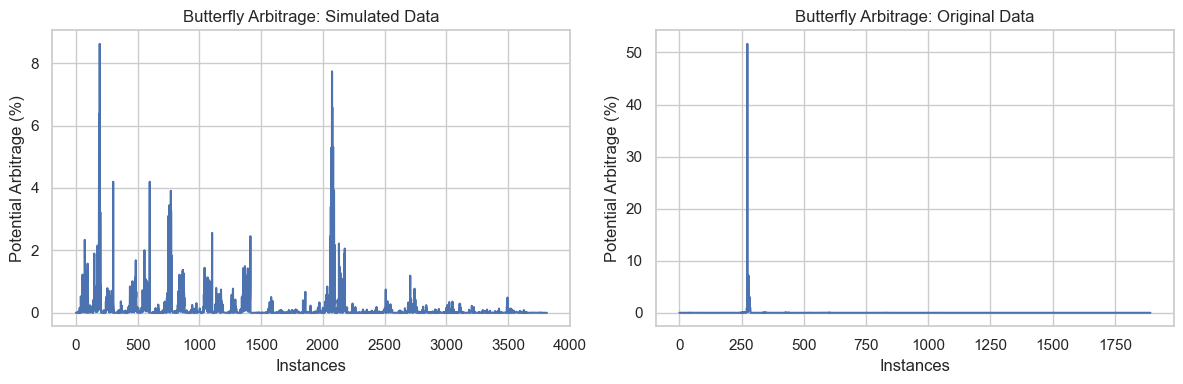

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

arbitrage_CSA_simulated_sorted = arbitrage_CSA_simulated.sort_index()
arbitrage_CSA_sorted = arbitrage_CSA.sort_index()

# Plot the first subplot
plt.subplot(1, 2, 1)
plt.plot(butterfly_arbitrage_simulated['arbitrage_percentage'] )
plt.ylabel('Potential Arbitrage (%)')
plt.xlabel('Instances')
plt.title('Butterfly Arbitrage: Simulated Data')

# Plot the second subplot
plt.subplot(1, 2, 2)
plt.plot(butterfly_arbitrage_df['arbitrage_percentage'])
plt.ylabel('Potential Arbitrage (%)')
plt.xlabel('Instances')
plt.title('Butterfly Arbitrage: Original Data')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()